In [37]:
#Summary analysis: in fig 1 we can see that younger mothers come surprisingly from military personnel type of coverage.
#fig 2 breaks down and shows how people with government support have higher chances of having a lower than healthy baby
#fig 3 shows that surprisingly natives have higher rate of overweight babies, with military personnel following.
#finally, fig 4 breaks down higher and lower weight of babies based on the number of children the mother had,
#the more risk she has of having an underweight baby, but that is also because the women are older on average by the third
#child so that has the risks associated accordingly. However, it is worth noting that for the first child there seem to also
#be a higher rate of low weight births. 

In [ ]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import requests
import json

In [2]:
#creating a DF out of the entire csv
births_df = pd.read_csv("2021_Data.csv")
births_df.head()

,dob_yy,dob_mm,dob_tt,bfacil,f_facility,bfacil3,mage_impflg,mage_repflg,mager,mager14,...,ca_downs,ca_disor,ca_hypo,f_ca_limb,f_ca_cleftlp,f_ca_cleft,f_ca_downs,f_ca_chrom,f_ca_hypos,no_congen
0,2021,1,636,1,1,1,NaN,NaN,22,8,...,N,N,N,1,1,1,1,1,1,1
1,2021,1,259,1,1,1,NaN,NaN,31,10,...,N,N,N,1,1,1,1,1,1,1
2,2021,1,223,1,1,1,NaN,NaN,29,9,...,N,N,N,1,1,1,1,1,1,1
3,2021,1,241,1,1,1,NaN,NaN,39,11,...,N,N,N,1,1,1,1,1,1,1
4,2021,1,503,1,1,1,NaN,NaN,20,8,...,N,N,N,1,1,1,1,1,1,1


# Data Cleaning: 

In [3]:
#choosing columns i want to examine more
clean_births_df = births_df[["dob_yy", "dob_mm","bfacil", "mager", "bmi_r", "priorlive", "priordead", "precare", "previs", "ld_anes", "attend","mm_aicu", "ab_nicu", "pay", "dbwt"]]
clean_births_df.head()

,dob_yy,dob_mm,bfacil,mager,bmi_r,priorlive,priordead,precare,previs,ld_anes,attend,mm_aicu,ab_nicu,pay,dbwt
0,2021,1,1,22,2,0,0,3,99,Y,1,N,N,5,3670
1,2021,1,1,31,3,1,0,99,99,Y,1,N,N,6,3210
2,2021,1,1,29,2,1,0,3,8,N,3,N,N,2,3997
3,2021,1,1,39,2,0,0,2,10,Y,2,N,N,1,3510
4,2021,1,1,20,2,0,0,3,11,N,1,N,N,1,3100


In [4]:
#rename columns 
clean_births_df = clean_births_df.rename(columns={"dob_yy":"Birth Year", "dob_mm":"Birth Month", 
                                                  "bfacil":"Birth Place", "mager":"Mother's Age", "bmi_r":"Mother's BMI",
                                                  "priorlive":"Living Children", "priordead":"Deceased Children",
                                                 "precare": "Prenatal Care", "previs": "# of Prenatal Visits",
                                                  "ld_anes": "Used Anesthesia", "attend":"Attendant at Birth",
                                                  "mm_aicu":"Intensive Care Admission", "ab_nicu": "NICU Admission", 
                                                  "pay":"Payment Source", "dbwt":"Birth Weight",
                                                 })
clean_births_df.head()


,Birth Year,Birth Month,Birth Place,Mother's Age,Mother's BMI,Living Children,Deceased Children,Prenatal Care,# of Prenatal Visits,Used Anesthesia,Attendant at Birth,Intensive Care Admission,NICU Admission,Payment Source,Birth Weight
0,2021,1,1,22,2,0,0,3,99,Y,1,N,N,5,3670
1,2021,1,1,31,3,1,0,99,99,Y,1,N,N,6,3210
2,2021,1,1,29,2,1,0,3,8,N,3,N,N,2,3997
3,2021,1,1,39,2,0,0,2,10,Y,2,N,N,1,3510
4,2021,1,1,20,2,0,0,3,11,N,1,N,N,1,3100


In [5]:
#Filtering out any data that is unknown (this is represented by the values 9 and/or 99)
clean_births_df = clean_births_df[~clean_births_df.apply(lambda row: any(x in [9, 99] for x in row), axis=1)]

In [6]:
clean_births_df.dtypes

Birth Year                   int64
Birth Month                  int64
Birth Place                  int64
Mother's Age                 int64
Mother's BMI                 int64
Living Children              int64
Deceased Children            int64
Prenatal Care                int64
# of Prenatal Visits         int64
Used Anesthesia             object
Attendant at Birth           int64
Intensive Care Admission    object
NICU Admission              object
Payment Source               int64
Birth Weight                 int64
dtype: object

In [7]:
#declaring recoding responses as objects to later replace with coded meaning
clean_births_df = clean_births_df.astype({"Birth Place":str}, errors='raise')
clean_births_df = clean_births_df.astype({"Mother's BMI":str}, errors='raise')
clean_births_df = clean_births_df.astype({"Attendant at Birth": str}, errors='raise')
clean_births_df = clean_births_df.astype({"Payment Source": str}, errors='raise')

In [8]:
#verify datatypes were changed
clean_births_df.dtypes

Birth Year                   int64
Birth Month                  int64
Birth Place                 object
Mother's Age                 int64
Mother's BMI                object
Living Children              int64
Deceased Children            int64
Prenatal Care                int64
# of Prenatal Visits         int64
Used Anesthesia             object
Attendant at Birth          object
Intensive Care Admission    object
NICU Admission              object
Payment Source              object
Birth Weight                 int64
dtype: object

In [9]:
#decoding inputs based on documentation

##For column: Birth place
clean_births_df["Birth Place"] = clean_births_df["Birth Place"].replace({"1":"Hospital", "2": "Freestanding Birth Center",
                                                                         "3":"Home (intended)", "4": "Home (unintended)",
                                                                        "5": "Home (intent unknown)", "6": "Clinic/Doctor's Office",
                                                                        "7":"Other",
                                                                        })
##For column: Mother's BMI
clean_births_df["Mother's BMI"] = clean_births_df["Mother's BMI"].replace({"1":"Underweight <18.5", "2":"Normal 18.5-24.9",
                                                                          "3": "Overweight 25.0-29.9", "4":"Obesity I 35.0-34.9",
                                                                          "5":"Obesity II 35.0-39.9", "6": "Extreme Obesity III ≥ 40.0",
                                                                          })
##For column: Prenatal Care
clean_births_df.loc[(clean_births_df['Prenatal Care'] >= 1) & (clean_births_df['Prenatal Care'] <= 10), 'Prenatal Care'] = 'Y'
clean_births_df.loc[(clean_births_df['Prenatal Care'] == 0), 'Prenatal Care'] = 'N'


##For column: Attendant at Birth
clean_births_df["Attendant at Birth"] = clean_births_df["Attendant at Birth"].replace({"1": "Doctor of Medicine (MD)", "2": "Doctor of Osteopathy (DO)",
                                                                                      "3":"Certified Nurse Midwife/Certified Midwife (CNM/CM)", "4":"Other Midwife",
                                                                                      "5": "Other",
                                                                                      })
##For column: Payment Source
clean_births_df["Payment Source"] = clean_births_df["Payment Source"].replace({"1":"Medicaid", "2":"Private Insurance",
                                                                              "3": "Self-Pay", "4":"Indian Health Service",
                                                                              "5":"CHAMPUS/TRICARE", "6":"Other Government (Federal, State, Local)",
                                                                              "8":"Other"})

#Show updated dataframe
clean_births_df.head()

,Birth Year,Birth Month,Birth Place,Mother's Age,Mother's BMI,Living Children,Deceased Children,Prenatal Care,# of Prenatal Visits,Used Anesthesia,Attendant at Birth,Intensive Care Admission,NICU Admission,Payment Source,Birth Weight
2,2021,1,Hospital,29,Normal 18.5-24.9,1,0,Y,8,N,Certified Nurse Midwife/Certified Midwife (CNM...,N,N,Private Insurance,3997
3,2021,1,Hospital,39,Normal 18.5-24.9,0,0,Y,10,Y,Doctor of Osteopathy (DO),N,N,Medicaid,3510
4,2021,1,Hospital,20,Normal 18.5-24.9,0,0,Y,11,N,Doctor of Medicine (MD),N,N,Medicaid,3100
5,2021,1,Hospital,29,Obesity II 35.0-39.9,0,0,Y,7,Y,Doctor of Medicine (MD),N,N,Private Insurance,3300
7,2021,1,Hospital,34,Normal 18.5-24.9,6,0,Y,11,N,Certified Nurse Midwife/Certified Midwife (CNM...,N,N,Private Insurance,3495


In [10]:
#convert baby birth weight from grams to pounds

# Conversion factor from grams to pounds
grams_to_pounds_conversion_factor = 0.00220462

clean_births_df["Birth Weight"] = clean_births_df["Birth Weight"] * grams_to_pounds_conversion_factor

#Rename column 
clean_births_df = clean_births_df.rename(columns={"Birth Weight":"Birth Weight (lbs)"})

#display 
clean_births_df.head()

,Birth Year,Birth Month,Birth Place,Mother's Age,Mother's BMI,Living Children,Deceased Children,Prenatal Care,# of Prenatal Visits,Used Anesthesia,Attendant at Birth,Intensive Care Admission,NICU Admission,Payment Source,Birth Weight (lbs)
2,2021,1,Hospital,29,Normal 18.5-24.9,1,0,Y,8,N,Certified Nurse Midwife/Certified Midwife (CNM...,N,N,Private Insurance,8.811866
3,2021,1,Hospital,39,Normal 18.5-24.9,0,0,Y,10,Y,Doctor of Osteopathy (DO),N,N,Medicaid,7.738216
4,2021,1,Hospital,20,Normal 18.5-24.9,0,0,Y,11,N,Doctor of Medicine (MD),N,N,Medicaid,6.834322
5,2021,1,Hospital,29,Obesity II 35.0-39.9,0,0,Y,7,Y,Doctor of Medicine (MD),N,N,Private Insurance,7.275246
7,2021,1,Hospital,34,Normal 18.5-24.9,6,0,Y,11,N,Certified Nurse Midwife/Certified Midwife (CNM...,N,N,Private Insurance,7.705147


In [11]:
#function to grab mean, median, and std_dev values from any given column in the dataframe
def perform_analysis(df, columns):

    analysis_df = df[columns]

    # Convert numeric columns to numeric data type with downcast, making sure to replace any non numbers with NaN
    #downcast converts the numeric value to the smallest one possible
    analysis_df = analysis_df.apply(lambda x: pd.to_numeric(x, errors='coerce', downcast='float'))

    # Calculate mean, median, and standard deviation values
    mean_values = analysis_df.mean()
    median_values = analysis_df.median()
    std_dev_values = analysis_df.std()

    return mean_values, median_values, std_dev_values



In [12]:
columns_to_analyze = ["Mother's Age", "Payment Source"]

# Perform analysis
mean_values, median_values, std_dev_values = perform_analysis(clean_births_df, columns_to_analyze)

# Display results
print("Mean Values:")
print(mean_values)
print("\nMedian Values:")
print(median_values)
print("\nStandard Deviation Values:")
print(std_dev_values)



Mean Values:
Mother's Age      27.739426
Payment Source          NaN
dtype: float32

Median Values:
Mother's Age      28.0
Payment Source     NaN
dtype: float32

Standard Deviation Values:
Mother's Age      5.662805
Payment Source         NaN
dtype: float32


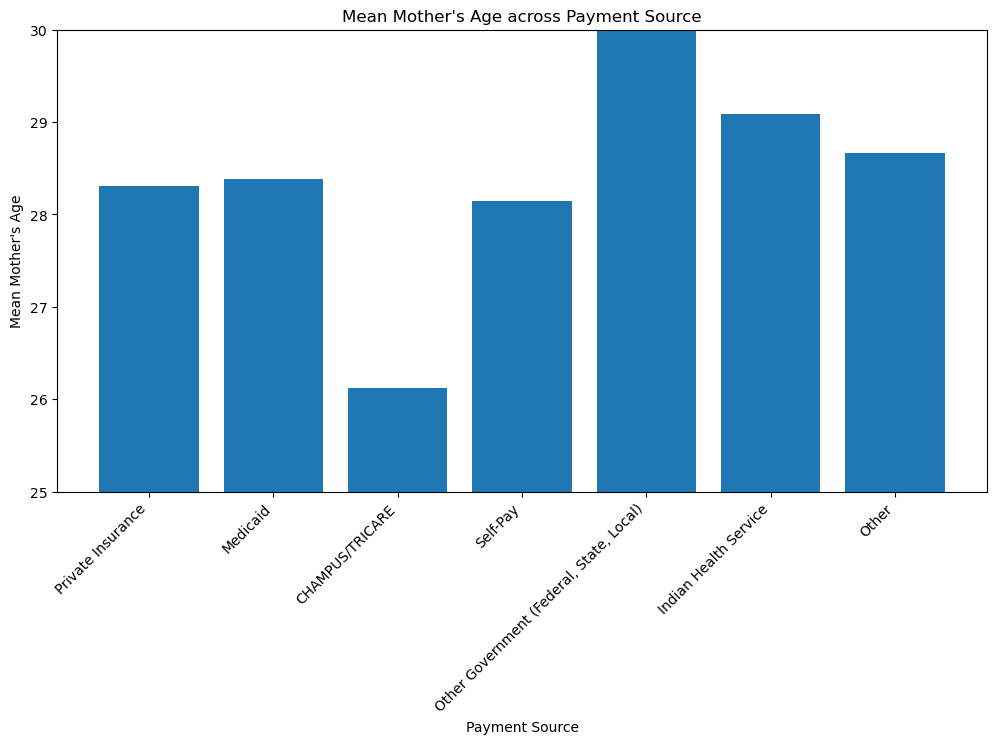

In [36]:
#plotting the mean age across payment source
plt.figure(figsize=(12, 6))
payment_source_values = clean_births_df['Payment Source'].unique()
mean_mother_age_values = clean_births_df.groupby('Payment Source')["Mother's Age"].mean()
plt.bar(payment_source_values, mean_mother_age_values)
plt.title("Mean Mother's Age across Payment Source")
plt.xlabel("Payment Source")
plt.ylabel("Mean Mother's Age")
plt.ylim(25, 30)  # Set Y-axis range from 25 to 30
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.savefig('mother_age_vs_payment_source.png')  # Save the plot as a PNG file
plt.show()#fig 1


In [21]:
# Find the maximum and minimum values of "Birth Weight (lbs)"
max_birth_weight = clean_births_df['Birth Weight (lbs)'].max()
min_birth_weight = clean_births_df['Birth Weight (lbs)'].min()

print(f"Maximum Birth Weight: {max_birth_weight} lbs")
print(f"Minimum Birth Weight: {min_birth_weight} lbs")



Maximum Birth Weight: 22.043995380000002 lbs
Minimum Birth Weight: 0.5004487400000001 lbs


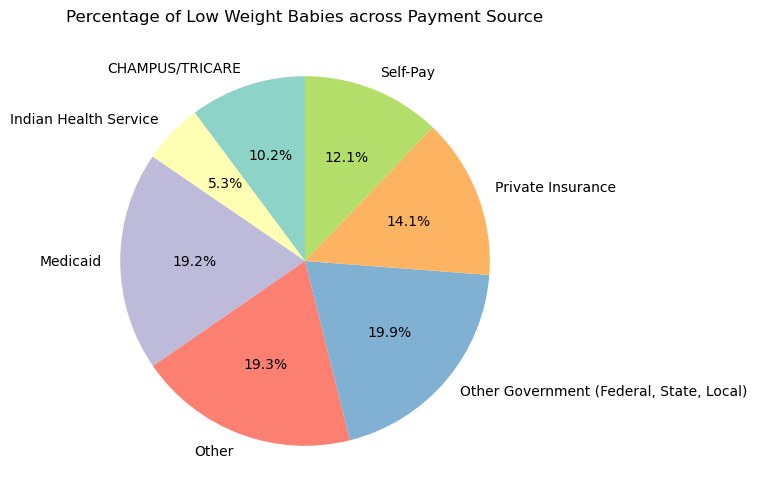

In [32]:
# Categorize babies into "low weight" and "high weight"
low_weight_threshold = 5
high_weight_threshold = 9

clean_births_df['Weight Category'] = pd.cut(clean_births_df['Birth Weight (lbs)'],
                                           bins=[-np.inf, low_weight_threshold, high_weight_threshold, np.inf],
                                           labels=['Low Weight', 'Normal Weight', 'High Weight'])

# Calculate the percentage of low-weight and high-weight babies in each payment source
weight_category_counts = clean_births_df[clean_births_df['Weight Category'] != 'Normal Weight']\
    .groupby(['Payment Source', 'Weight Category']).size().unstack()

weight_category_percentages = weight_category_counts.div(weight_category_counts.sum(axis=1), axis=0) * 100

# Plot the pie chart for Low Weight percentage
plt.figure(figsize=(12, 6))
labels = weight_category_percentages.index

colors_low_weight = plt.cm.Set3(np.arange(len(labels))) #makes sure each one gets a different color
plt.pie(weight_category_percentages['Low Weight'], 
        labels=labels, autopct='%1.1f%%', startangle=90, colors=colors_low_weight)
plt.title("Percentage of Low Weight Babies across Payment Source")
plt.savefig('percentage_low_weight_pie_chart.png')
plt.show() #fig 2

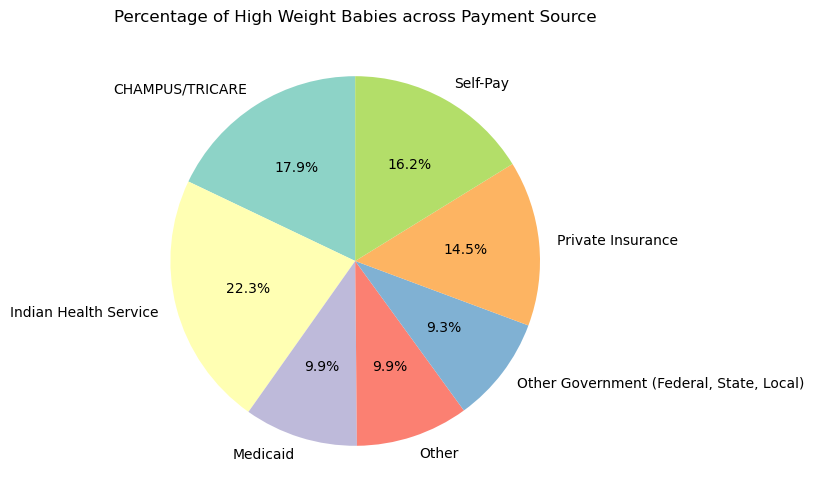

In [33]:
# Plot the pie chart for High Weight percentage
plt.figure(figsize=(12, 6))
labels = weight_category_percentages.index
colors_high_weight = plt.cm.Set3(np.arange(len(labels)))
plt.pie(weight_category_percentages['High Weight'], 
        labels=labels, autopct='%1.1f%%', startangle=90, colors=colors_high_weight)
plt.title("Percentage of High Weight Babies across Payment Source")
plt.savefig('percentage_high_weight_pie_chart.png')
plt.show()#fig 3

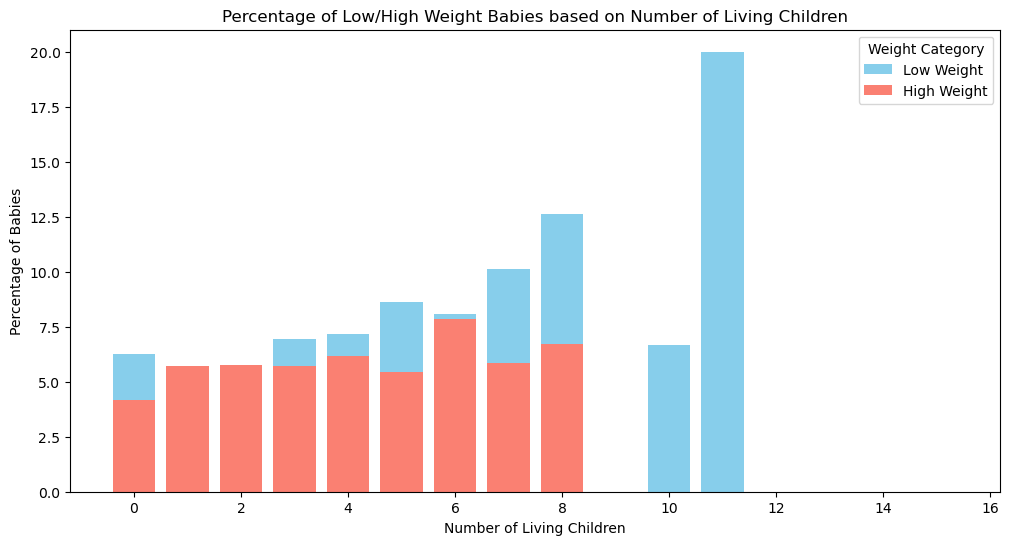

In [34]:
# Create a new DataFrame with relevant columns
child_weight_df = clean_births_df[['Living Children', 'Weight Category']]

# Group by 'Living Children' and 'Weight Category', calculate count, and unstack
child_weight_counts = child_weight_df.groupby(['Living Children', 'Weight Category']).size().unstack()

# Calculate the total number of babies for each number of living children
total_babies_per_child = child_weight_counts.sum(axis=1)

# Calculate the percentage of low-weight and high-weight babies for each number of living children
child_weight_percentages = child_weight_counts.div(total_babies_per_child, axis=0) * 100

# Plot the comparison between the number of living children and the percentage of low/high-weight babies
plt.figure(figsize=(12, 6))

# Set the color map for each weight category
colors = {'Low Weight': 'skyblue', 'High Weight': 'salmon'}

# Plot each bar for Low Weight and High Weight
#zero out the percentages making sure then length is equal to the amount of categories 
bottom_low_weight = np.zeros(len(child_weight_percentages))
bottom_high_weight = np.zeros(len(child_weight_percentages))

for weight_category in ['Low Weight', 'High Weight']:
    plt.bar(
        child_weight_percentages.index,
        child_weight_percentages[weight_category],
        #bottom is used to set the starting height of each bar
        bottom=(bottom_low_weight if weight_category == 'Low Weight' else bottom_high_weight),
        label=weight_category,
        color=colors[weight_category]
    )

    if weight_category == 'Low Weight':
        bottom_low_weight += child_weight_percentages[weight_category]
    else:
        bottom_high_weight += child_weight_percentages[weight_category]

plt.title("Percentage of Low/High Weight Babies based on Number of Living Children")
plt.xlabel("Number of Living Children")
plt.ylabel("Percentage of Babies")
plt.legend(title='Weight Category')
plt.savefig('living_children_vs_weight_category_percentage_chart.png')
plt.show() #fig 4



In [38]:
# Group by 'Living Children' and calculate the mean age
average_mother_age_per_child = clean_births_df.groupby('Living Children')["Mother's Age"].mean()

# Display the results

average_mother_age_per_child.head()


Living Children
0    25.254944
1    28.097386
2    29.668705
3    30.816275
4    31.916598
Name: Mother's Age, dtype: float64